In [3]:
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import knn_graph
import os.path as osp
import pandas as pd
import numpy as np
import torch
import h5py

class AudioGraphDataset(Dataset):
    def __init__(self, root, path, k_neigh=5, enable=False, transform=None, pre_transform=None, pre_filter=None):
        """
        Initialize the Audio Graph Dataset
        Args:
            root: Root directory for processed files
            path: List containing paths to [csv_file, hdf5_file]
            k_neigh: Number of nearest neighbors for graph construction
            enable: Flag for extended processing mode
            transform: Transform to be applied to the data
            pre_transform: Transform to be applied before processing
            pre_filter: Filter to be applied before processing
        """
        self.csv_path = path[0]
        self.hdf5_path = path[1]
        self.enable = enable
        self.k_neigh = k_neigh
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        # Return the actual filenames without full paths
        return [osp.basename(self.csv_path), osp.basename(self.hdf5_path)]

    @property
    def raw_dir(self) -> str:
        # Return the directory containing the raw files
        return osp.dirname(self.csv_path)

    @property
    def processed_file_names(self):
        # Return list of processed file names based on enable flag
        if not self.enable:
            return [f'data_{i}.pt' for i in range(10)]
        else:
            return [f'data_{i}.pt' for i in range(109)]

    def download(self):
        # No download needed as we're using local files
        pass

    def process(self):
        """
        Process the raw data into graph format
        - Loads features and labels from HDF5
        - Performs cross-validation splits
        - Creates graph structure using kNN
        - Saves processed graphs
        """
        # Load metadata and features using full paths
        self.df = pd.read_csv(self.csv_path)
        self.data = h5py.File(self.hdf5_path, 'r')
        
        # Convert features and labels to torch tensors
        X_tensor = torch.tensor(np.array(self.data['features']))
        Y_tensor = torch.tensor(np.array(self.data['labels']))

        if not self.enable:
            # Standard processing mode - 10 fold cross validation
            self._process_folds(X_tensor, Y_tensor, 0, 10)
        else:
            # Extended processing mode - varying k neighbors
            for k in range(5, 115, 10):
                start_idx = (k - 5) // 10 * 10
                self._process_folds(X_tensor, Y_tensor, start_idx, 10, k)

    def _process_folds(self, X_tensor, Y_tensor, start_idx, num_folds, k_neighbors=None):
        """
        Process data for multiple cross-validation folds
        """
        test_idx = 1
        val_idx = 2
        k = k_neighbors if k_neighbors is not None else self.k_neigh

        for j in range(start_idx, start_idx + num_folds):
            # Get train/test/validation splits
            idx_train, idx_test, idx_val = self._cross_validation_split(
                self.df, test_idx, val_idx)
            
            # Normalize features
            X_tensor_norm = self._normalize_features(X_tensor, idx_train)
            
            # Create graph data object
            data = self._create_graph(X_tensor_norm, Y_tensor, 
                                    idx_train, idx_test, idx_val, k)
            
            # Save processed data
            torch.save(data, osp.join(self.processed_dir, f'data_{j}.pt'))
            
            # Update indices for next fold
            test_idx = (test_idx + 1) % 11
            val_idx = (val_idx + 1) % 11
            if val_idx == 0:
                val_idx = 1

    def _normalize_features(self, X_tensor, idx_train):
        """
        Normalize features using min-max scaling based on training set
        """
        mini = X_tensor[idx_train].min()
        maxi = X_tensor[idx_train].max()
        return (X_tensor - mini) / (maxi - mini)

    def _cross_validation_split(self, df, idx_test, idx_val):
        """
        Create train/test/validation splits using fold information
        """
        df = df.reset_index(drop=True)
        df_train = df.copy()
        
        # Get test indices and remove from training
        idx_test_mask = df.index[df.fold == idx_test]
        df_train.drop(idx_test_mask, inplace=True)
        
        # Get validation indices and remove from training
        idx_val_mask = df.index[df.fold == idx_val]
        df_train.drop(idx_val_mask, inplace=True)
        
        # Remaining indices are training set
        idx_train_mask = df_train.index
        
        return idx_train_mask, idx_test_mask, idx_val_mask

    def _create_graph(self, X_tensor, Y_tensor, idx_train, idx_test, idx_val, k):
        """
        Create a graph using feature tensors and kNN
        """
        # Convert indices to tensors
        train_mask = torch.tensor(idx_train)
        test_mask = torch.tensor(idx_test)
        val_mask = torch.tensor(idx_val)

        # Create edge connections using kNN
        edge_index = knn_graph(X_tensor, k=k, batch=Y_tensor, loop=False)

        # Create and return the graph data object
        return Data(
            x=X_tensor,
            edge_index=edge_index,
            y=Y_tensor,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask
        )

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """Load and return a specific graph"""
        return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))

In [4]:
# Example usage
dataset = AudioGraphDataset(
    root='data_vggish_fixed_knn/processed',
    path=['data_vggish_fixed_knn/raw/UrbanSound8K7780.csv', 'data_vggish_fixed_knn/raw/TF_vggish_2023.hdf5'],
    k_neigh=5
)

# Access a specific graph
graph = dataset[0]

Processing...
Done!
/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import numpy as np

def visualize_graph(data, title="Audio Graph Visualization", color_by='label', fig_size=(12, 8)):
    """
    Visualize the audio graph with different coloring options
    
    Args:
        data: PyG Data object containing the graph
        title: Title for the visualization
        color_by: 'label' or 'split' to color nodes by class labels or train/val/test split
        fig_size: Size of the figure (width, height)
    """
    # Convert to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Get node positions using spring layout
    pos = nx.spring_layout(G, k=0.5)  # k controls the distance between nodes
    
    plt.figure(figsize=fig_size)
    
    if color_by == 'label':
        # Color by class labels
        labels = data.y.numpy()
        unique_labels = np.unique(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        color_dict = dict(zip(unique_labels, colors))
        node_colors = [color_dict[label] for label in labels]
        
        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color,
                                    label=f'Class {label}', markersize=10)
                         for label, color in color_dict.items()]
        
    else:  # color_by == 'split'
        # Color by train/val/test split
        colors = []
        for i in range(len(G)):
            if i in data.train_mask:
                colors.append('blue')
            elif i in data.val_mask:
                colors.append('green')
            elif i in data.test_mask:
                colors.append('red')
        node_colors = colors
        
        # Create legend handles
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      label='Train', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                      label='Validation', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                      label='Test', markersize=10)
        ]
    
    # Draw the graph
    nx.draw(G, pos, node_color=node_colors, node_size=100, alpha=0.7)
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()

def visualize_graph_metrics(data):
    """
    Visualize graph metrics such as degree distribution
    
    Args:
        data: PyG Data object containing the graph
    """
    G = to_networkx(data, to_undirected=True)
    
    # Calculate degree for each node
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, alpha=0.7)
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()
    
    # Print some graph statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
    print(f"Graph density: {nx.density(G):.4f}")

/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


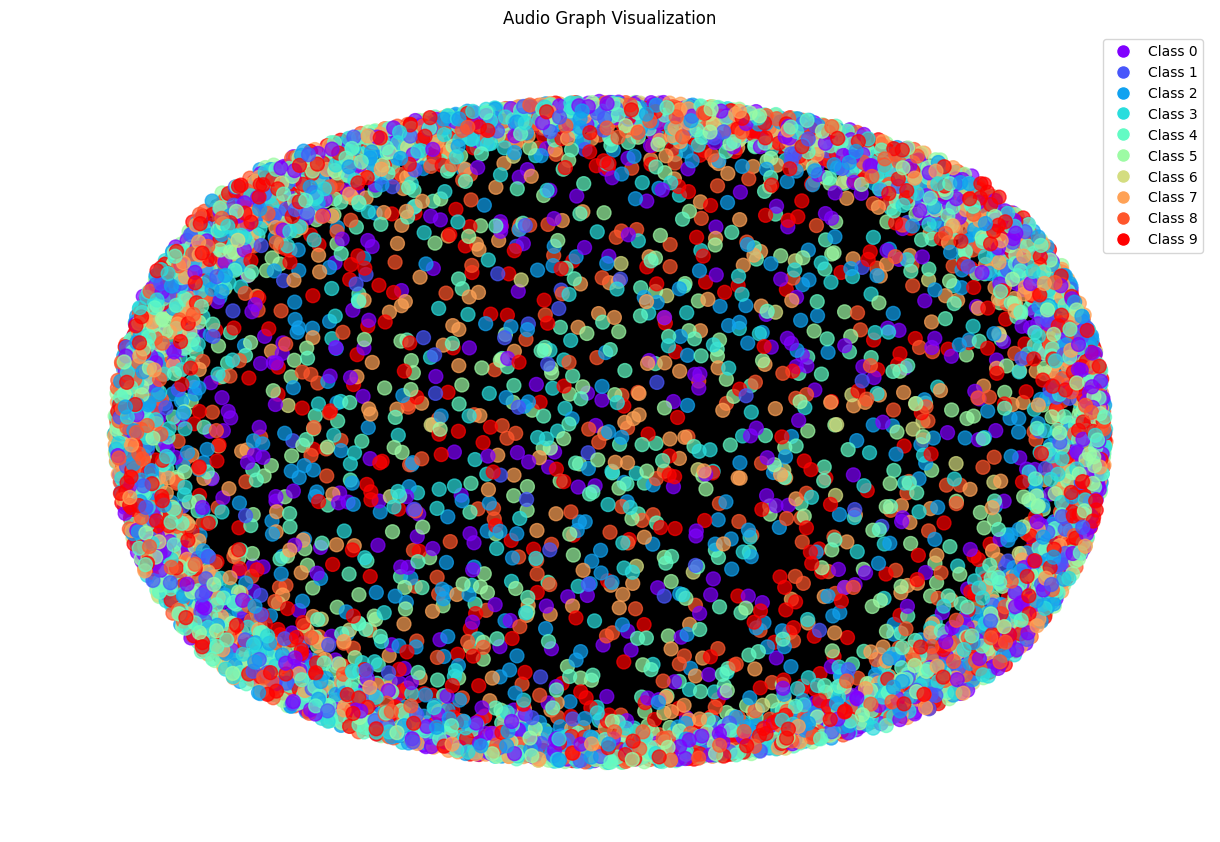

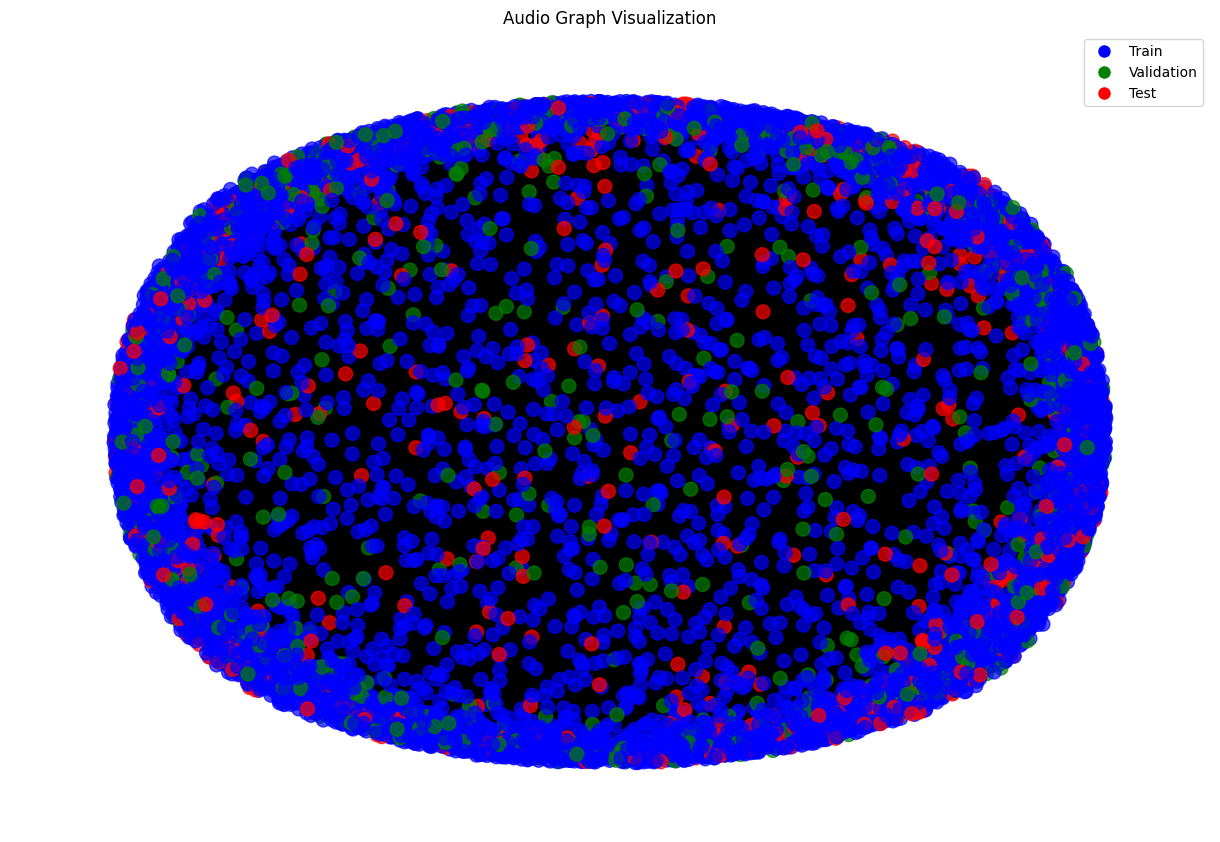

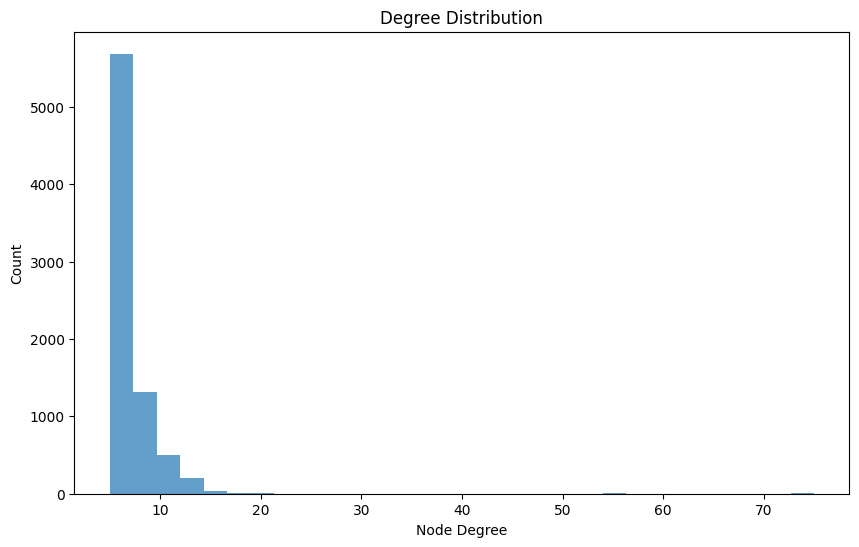

Number of nodes: 7780
Number of edges: 26575
Average degree: 6.83
Graph density: 0.0009


In [6]:
dataset = AudioGraphDataset(
    root='data_vggish_fixed_knn/processed',
    path=['data_vggish_fixed_knn/raw/UrbanSound8K7780.csv', 'data_vggish_fixed_knn/raw/TF_vggish_2023.hdf5'],
    k_neigh=5
)
# Get a specific graph
graph = dataset[0]

# Visualize the graph with nodes colored by class labels
visualize_graph(graph, color_by='label')

# Visualize the graph with nodes colored by train/val/test split
visualize_graph(graph, color_by='split')

# Visualize graph metrics
visualize_graph_metrics(graph)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import numpy as np

def visualize_graph_with_edges(data, title="Audio Graph Visualization", color_by='label',
                                layout='spring', fig_size=(12, 8), edge_alpha=0.1, 
                                node_size=100, edge_size=0.5):
    """
    Visualize the audio graph with edges (transparent), different layout options and tunable node/edge sizes.
    
    Args:
        data: PyG Data object containing the graph
        title: Title for the visualization
        color_by: 'label' or 'split' to color nodes by class labels or train/val/test split
        layout: Layout algorithm ('spring', 'circular', 'spectral', 'random')
        fig_size: Size of the figure (width, height)
        edge_alpha: Transparency of the edges (0=invisible, 1=opaque)
        node_size: Size of the nodes
        edge_size: Size (linewidth) of the edges
    """
    # Convert to networkx graph
    G = to_networkx(data, to_undirected=True)
    
    # Get node positions based on layout algorithm
    if layout == 'spring':
        pos = nx.spring_layout(G, k=0.5)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'spectral':
         pos = nx.spectral_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    else:
       raise ValueError("Invalid layout algorithm. Choose from 'spring', 'circular', 'spectral', or 'random'.")
    
    plt.figure(figsize=fig_size)
    
    if color_by == 'label':
        # Color by class labels
        labels = data.y.numpy()
        unique_labels = np.unique(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        color_dict = dict(zip(unique_labels, colors))
        node_colors = [color_dict[label] for label in labels]
        
        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color,
                                    label=f'Fold {label}', markersize=10)
                         for label, color in color_dict.items()]
        
    else:  # color_by == 'split'
        # Color by train/val/test split
        colors = []
        for i in range(len(G)):
            if i in data.train_mask:
                colors.append('blue')
            elif i in data.val_mask:
                colors.append('green')
            elif i in data.test_mask:
                colors.append('red')
        node_colors = colors
        
        # Create legend handles
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      label='Train', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                      label='Validation', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                      label='Test', markersize=10)
        ]
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha, width=edge_size)

    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.show()


def visualize_graph_metrics(data):
    """
    Visualize graph metrics such as degree distribution
    
    Args:
        data: PyG Data object containing the graph
    """
    G = to_networkx(data, to_undirected=True)
    
    # Calculate degree for each node
    degrees = [d for n, d in G.degree()]
    
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, alpha=0.7)
    plt.xlabel('Node Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()
    
    # Print some graph statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
    print(f"Graph density: {nx.density(G):.4f}")

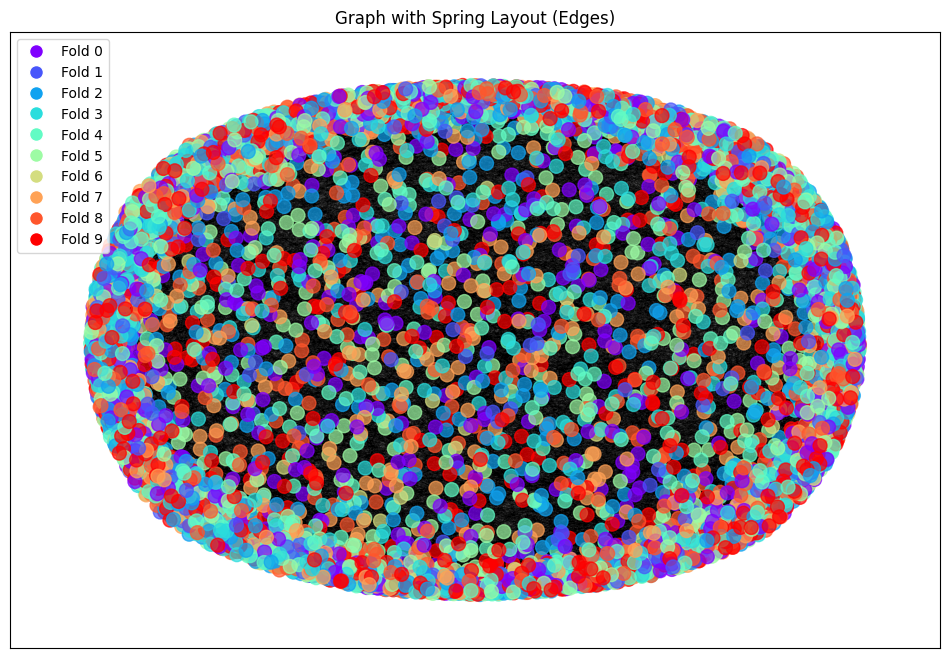

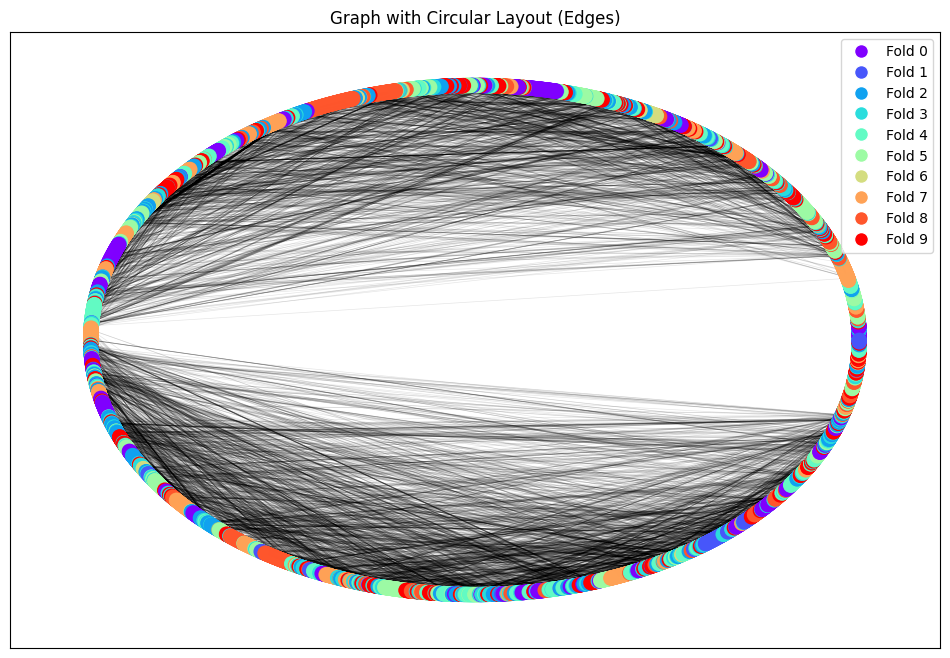

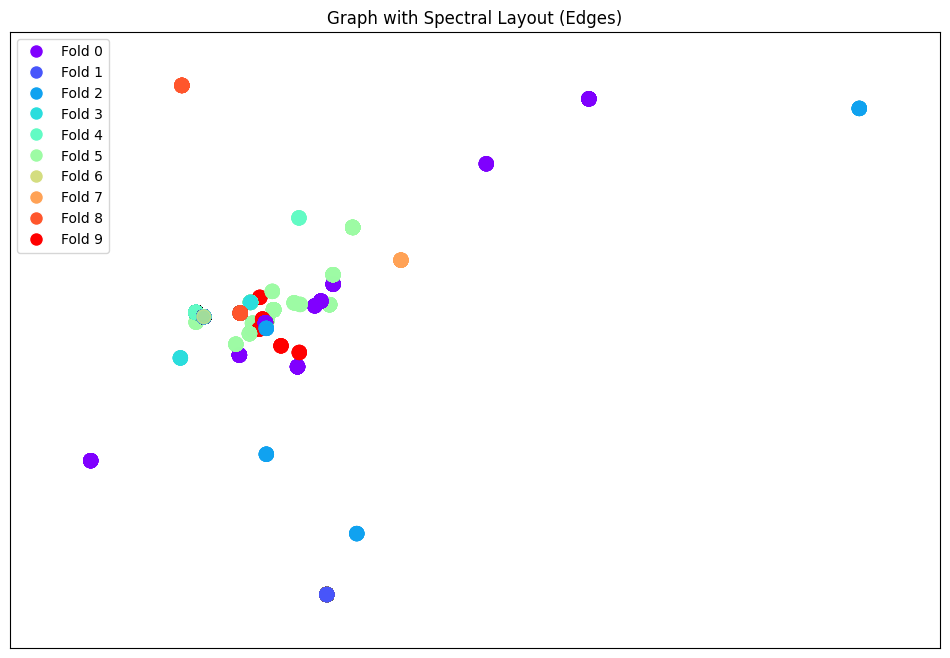

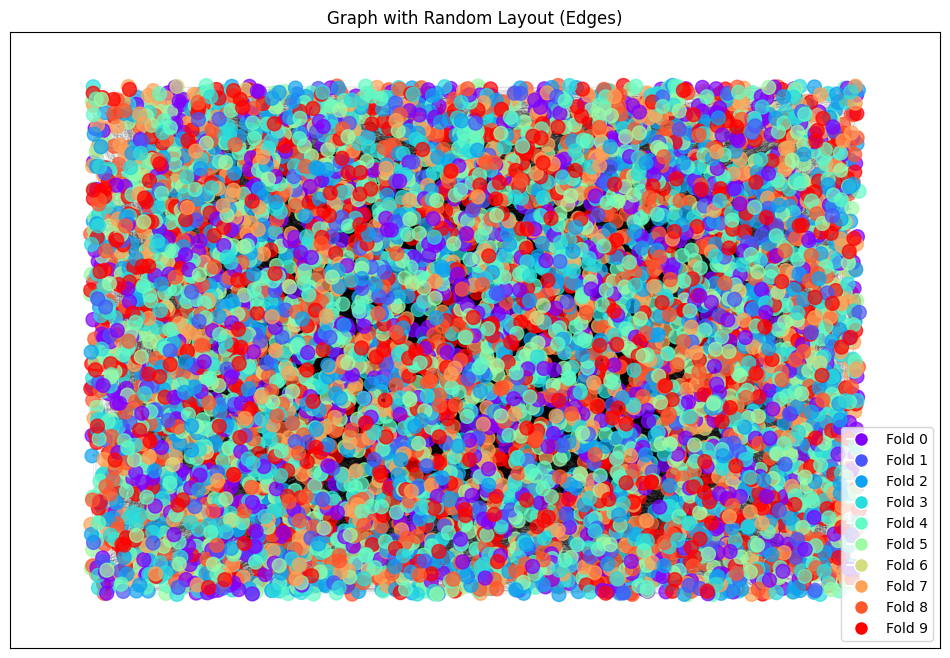

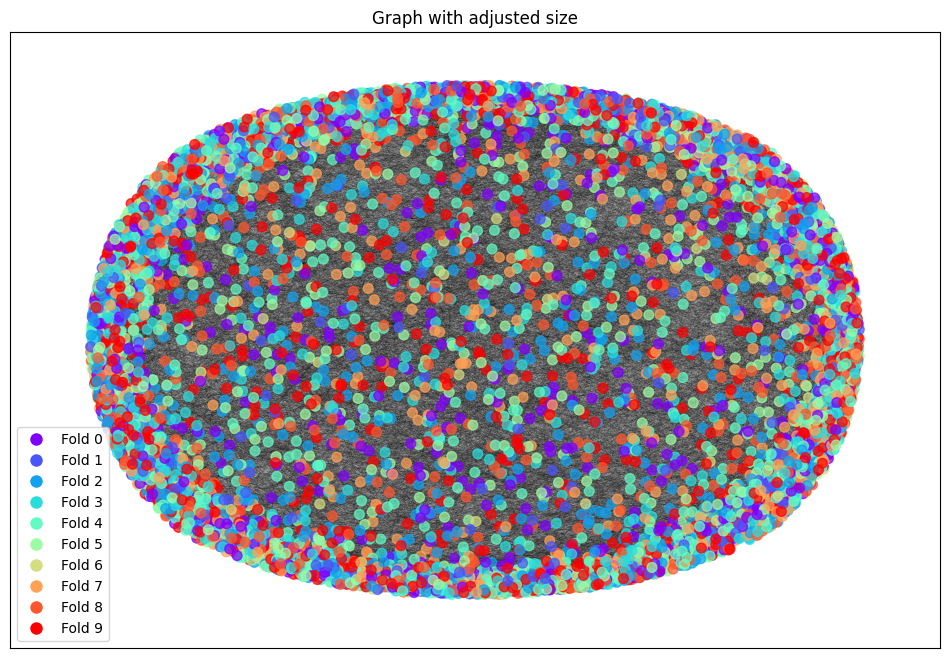

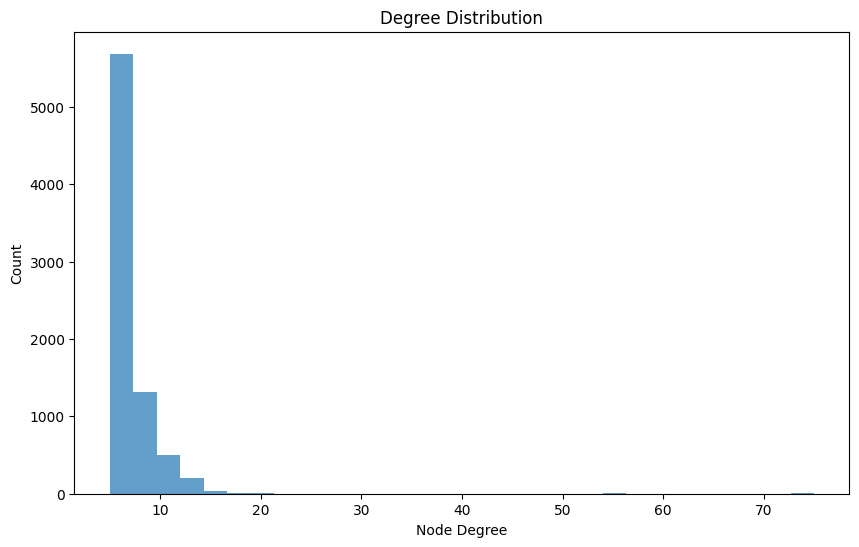

Number of nodes: 7780
Number of edges: 26575
Average degree: 6.83
Graph density: 0.0009


In [8]:
# Assuming you have loaded a PyG Data object named 'data'
# Visualize with edges, spring layout, with low transparency:
visualize_graph_with_edges(graph, title="Graph with Spring Layout (Edges)",
                          color_by='label', layout='spring', edge_alpha=0.1)

# Visualize with edges, circular layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Circular Layout (Edges)",
                          color_by='label', layout='circular', edge_alpha=0.1)

# Visualize with edges, spectral layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Spectral Layout (Edges)",
                          color_by='label', layout='spectral', edge_alpha=0.1)

# Visualize with edges, random layout, with low transparency
visualize_graph_with_edges(graph, title="Graph with Random Layout (Edges)",
                          color_by='label', layout='random', edge_alpha=0.1)

visualize_graph_with_edges(graph, title="Graph with adjusted size",
                          color_by='label', layout='spring', edge_alpha=0.1, 
                          node_size=50, edge_size=0.2)


# Visualize graph metrics
visualize_graph_metrics(graph)

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
class GCNAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.3):
        """
        GCN model for audio classification
        Args:
            num_features: Number of input features (128 for VGGish)
            hidden_channels: Number of hidden units
            num_classes: Number of output classes
            dropout: Dropout rate
        """
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Batch normalization
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)  # Batch normalization

    def forward(self, x, edge_index):
        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final Graph Convolution
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [10]:
def train_model(model, data, optimizer, epochs=200):
    """
    Train the GCN model with early stopping
    Args:
        model: GCN model instance
        data: PyG Data object containing the graph
        optimizer: PyTorch optimizer
        epochs: Number of training epochs
    Returns:
        lists of training/validation losses and accuracies
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 20  # Number of epochs to wait for improvement
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # Calculate loss only on training nodes
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            
            # Training metrics
            train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
            train_acc = accuracy_score(data.y[data.train_mask].cpu(), 
                                    out[data.train_mask].argmax(dim=1).cpu())
            
            # Validation metrics
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy_score(data.y[data.val_mask].cpu(), 
                                   out[data.val_mask].argmax(dim=1).cpu())
            
        # Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

In [11]:
def evaluate_model(model, data):
    """
    Evaluate the model on test set
    Args:
        model: Trained GCN model
        data: PyG Data object containing the graph
    Returns:
        dict containing various metrics
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1).cpu()
        true = data.y[data.test_mask].cpu()
        
        # Calculate metrics
        accuracy = accuracy_score(true, pred)
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='weighted')
        
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:
from collections import defaultdict

def train_k_fold(dataset, hidden_channels=32, dropout=0.3, epochs=200, lr=0.01):
    """
    Perform k-fold cross validation training with L2 regularization and learning rate scheduling
    Args:
        dataset: AudioGraphDataset instance
        hidden_channels: Number of hidden units in GCN
        dropout: Dropout rate
        epochs: Number of epochs per fold
        lr: Learning rate
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Store metrics for each fold
    fold_metrics = defaultdict(list)
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []
    
    print(f"Training on {len(dataset)} folds...")
    
    for fold in range(len(dataset)):
        print(f"\nTraining Fold {fold + 1}/{len(dataset)}")
        
        # Get graph data for current fold
        data = dataset[fold].to(device)
        
        # Initialize model for this fold
        model = GCNAudioClassifier(
            num_features=128,  # VGGish features dimension
            hidden_channels=hidden_channels,
            num_classes=10,    # UrbanSound8K classes
            dropout=dropout
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # L2 regularization
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)  # LR scheduling
        
        # Train on this fold
        train_losses, val_losses, train_accs, val_accs = train_model(
            model=model,
            data=data,
            optimizer=optimizer,
            epochs=epochs
        )
        
        # Store training curves
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)
        
        # Evaluate on test set
        test_metrics = evaluate_model(model, data)
        for metric, value in test_metrics.items():
            fold_metrics[metric].append(value)
        
        print(f"Fold {fold + 1} Test Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
    
    # Calculate average metrics across folds
    print("\nOverall Cross-Validation Results:")
    for metric, values in fold_metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"{metric.capitalize()}: {mean_value:.4f} ± {std_value:.4f}")
    
    return fold_metrics, (all_train_losses, all_val_losses, all_train_accs, all_val_accs)

In [13]:
def plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs):
    """Plot average training curves across all folds with standard deviation"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Find the maximum length across all folds
    max_length = max(len(fold) for fold in all_train_losses)
    
    # Pad shorter folds with NaN values to make all folds the same length
    def pad_fold(fold, max_length):
        return np.pad(fold, (0, max_length - len(fold)), mode='constant', constant_values=np.nan)
    
    all_train_losses = [pad_fold(fold, max_length) for fold in all_train_losses]
    all_val_losses = [pad_fold(fold, max_length) for fold in all_val_losses]
    all_train_accs = [pad_fold(fold, max_length) for fold in all_train_accs]
    all_val_accs = [pad_fold(fold, max_length) for fold in all_val_accs]
    
    # Convert to numpy arrays
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)
    
    # Calculate mean and std for losses
    train_losses_mean = np.nanmean(all_train_losses, axis=0)  # Ignore NaNs
    train_losses_std = np.nanstd(all_train_losses, axis=0)    # Ignore NaNs
    val_losses_mean = np.nanmean(all_val_losses, axis=0)      # Ignore NaNs
    val_losses_std = np.nanstd(all_val_losses, axis=0)        # Ignore NaNs
    
    # Calculate mean and std for accuracies
    train_accs_mean = np.nanmean(all_train_accs, axis=0)      # Ignore NaNs
    train_accs_std = np.nanstd(all_train_accs, axis=0)        # Ignore NaNs
    val_accs_mean = np.nanmean(all_val_accs, axis=0)          # Ignore NaNs
    val_accs_std = np.nanstd(all_val_accs, axis=0)            # Ignore NaNs
    
    # Plot losses
    epochs = range(1, len(train_losses_mean) + 1)
    ax1.plot(epochs, train_losses_mean, label='Train Loss')
    ax1.fill_between(epochs, train_losses_mean - train_losses_std, 
                    train_losses_mean + train_losses_std, alpha=0.2)
    ax1.plot(epochs, val_losses_mean, label='Validation Loss')
    ax1.fill_between(epochs, val_losses_mean - val_losses_std,
                    val_losses_mean + val_losses_std, alpha=0.2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Average Training and Validation Loss')
    
    # Plot accuracies
    ax2.plot(epochs, train_accs_mean, label='Train Accuracy')
    ax2.fill_between(epochs, train_accs_mean - train_accs_std,
                    train_accs_mean + train_accs_std, alpha=0.2)
    ax2.plot(epochs, val_accs_mean, label='Validation Accuracy')
    ax2.fill_between(epochs, val_accs_mean - val_accs_std,
                    val_accs_mean + val_accs_std, alpha=0.2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Average Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

Training on 10 folds...

Training Fold 1/10


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 010, Train Loss: 1.2875, Train Acc: 0.6674, Val Loss: 1.4127, Val Acc: 0.5907
Epoch 020, Train Loss: 0.6749, Train Acc: 0.7859, Val Loss: 1.0128, Val Acc: 0.6474
Epoch 030, Train Loss: 0.5846, Train Acc: 0.8004, Val Loss: 1.0917, Val Acc: 0.6873
Epoch 040, Train Loss: 0.4517, Train Acc: 0.8549, Val Loss: 1.2732, Val Acc: 0.6898
Early stopping at epoch 41
Fold 1 Test Metrics:
Accuracy: 0.7646
Precision: 0.8207
Recall: 0.7646
F1: 0.7483

Training Fold 2/10
Epoch 010, Train Loss: 1.2703, Train Acc: 0.7240, Val Loss: 1.4659, Val Acc: 0.5893


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 020, Train Loss: 0.7704, Train Acc: 0.7384, Val Loss: 1.1590, Val Acc: 0.6821
Epoch 030, Train Loss: 0.6339, Train Acc: 0.7616, Val Loss: 1.1660, Val Acc: 0.6762
Early stopping at epoch 37
Fold 2 Test Metrics:
Accuracy: 0.6345
Precision: 0.7332
Recall: 0.6345
F1: 0.6443

Training Fold 3/10
Epoch 010, Train Loss: 1.1425, Train Acc: 0.6904, Val Loss: 1.2289, Val Acc: 0.6362
Epoch 020, Train Loss: 0.7408, Train Acc: 0.7499, Val Loss: 0.9853, Val Acc: 0.6751
Epoch 030, Train Loss: 0.5080, Train Acc: 0.8389, Val Loss: 0.8414, Val Acc: 0.7471
Epoch 040, Train Loss: 0.3661, Train Acc: 0.8900, Val Loss: 0.8259, Val Acc: 0.7334
Epoch 050, Train Loss: 0.3105, Train Acc: 0.9108, Val Loss: 0.8233, Val Acc: 0.7483
Epoch 060, Train Loss: 0.2802, Train Acc: 0.9202, Val Loss: 0.9420, Val Acc: 0.7094
Early stopping at epoch 68
Fold 3 Test Metrics:
Accuracy: 0.6202
Precision: 0.6457
Recall: 0.6202
F1: 0.6174

Training Fold 4/10
Epoch 010, Train Loss: 1.3335, Train Acc: 0.6692, Val Loss: 1.4734, Va

/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 030, Train Loss: 0.4731, Train Acc: 0.8581, Val Loss: 0.8401, Val Acc: 0.7213
Epoch 040, Train Loss: 0.3934, Train Acc: 0.8878, Val Loss: 0.8259, Val Acc: 0.7189
Epoch 050, Train Loss: 0.3699, Train Acc: 0.8917, Val Loss: 0.9396, Val Acc: 0.6868
Early stopping at epoch 54
Fold 4 Test Metrics:
Accuracy: 0.7037
Precision: 0.7357
Recall: 0.7037
F1: 0.6991

Training Fold 5/10
Epoch 010, Train Loss: 1.1544, Train Acc: 0.6683, Val Loss: 1.3631, Val Acc: 0.5809
Epoch 020, Train Loss: 0.7134, Train Acc: 0.7666, Val Loss: 1.0308, Val Acc: 0.6473


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 030, Train Loss: 0.5733, Train Acc: 0.8106, Val Loss: 1.0412, Val Acc: 0.6846
Epoch 040, Train Loss: 0.4436, Train Acc: 0.8618, Val Loss: 1.0271, Val Acc: 0.7040
Early stopping at epoch 44
Fold 5 Test Metrics:
Accuracy: 0.7189
Precision: 0.7161
Recall: 0.7189
F1: 0.7013

Training Fold 6/10
Epoch 010, Train Loss: 1.2242, Train Acc: 0.6311, Val Loss: 1.3659, Val Acc: 0.5645
Epoch 020, Train Loss: 0.6827, Train Acc: 0.7855, Val Loss: 0.9806, Val Acc: 0.6487
Epoch 030, Train Loss: 0.5067, Train Acc: 0.8522, Val Loss: 0.8447, Val Acc: 0.7171
Epoch 040, Train Loss: 0.4565, Train Acc: 0.8544, Val Loss: 0.9704, Val Acc: 0.6618
Early stopping at epoch 50
Fold 6 Test Metrics:
Accuracy: 0.7220
Precision: 0.7281
Recall: 0.7220
F1: 0.7162

Training Fold 7/10
Epoch 010, Train Loss: 1.3590, Train Acc: 0.6974, Val Loss: 1.4865, Val Acc: 0.5329
Epoch 020, Train Loss: 0.6097, Train Acc: 0.8333, Val Loss: 1.0681, Val Acc: 0.6238
Epoch 030, Train Loss: 0.5191, Train Acc: 0.8309, Val Loss: 1.2016, Va

/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Early stopping at epoch 40
Fold 7 Test Metrics:
Accuracy: 0.6658
Precision: 0.6658
Recall: 0.6658
F1: 0.6565

Training Fold 8/10
Epoch 010, Train Loss: 1.3066, Train Acc: 0.6336, Val Loss: 1.3092, Val Acc: 0.6586
Epoch 020, Train Loss: 0.6447, Train Acc: 0.8076, Val Loss: 0.7621, Val Acc: 0.7733
Epoch 030, Train Loss: 0.4840, Train Acc: 0.8431, Val Loss: 0.6807, Val Acc: 0.7962
Epoch 040, Train Loss: 0.3789, Train Acc: 0.8923, Val Loss: 0.7090, Val Acc: 0.7611
Epoch 050, Train Loss: 0.3103, Train Acc: 0.9105, Val Loss: 0.8537, Val Acc: 0.7530
Early stopping at epoch 54
Fold 8 Test Metrics:
Accuracy: 0.7049
Precision: 0.7183
Recall: 0.7049
F1: 0.6998

Training Fold 9/10
Epoch 010, Train Loss: 1.2660, Train Acc: 0.6890, Val Loss: 1.3124, Val Acc: 0.6919
Epoch 020, Train Loss: 0.7521, Train Acc: 0.7482, Val Loss: 0.9145, Val Acc: 0.6826
Epoch 030, Train Loss: 0.5836, Train Acc: 0.8175, Val Loss: 0.8374, Val Acc: 0.7583
Epoch 040, Train Loss: 0.4418, Train Acc: 0.8575, Val Loss: 0.8249, Va

/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 050, Train Loss: 0.3589, Train Acc: 0.8939, Val Loss: 0.7568, Val Acc: 0.7676
Epoch 060, Train Loss: 0.3158, Train Acc: 0.9028, Val Loss: 0.7958, Val Acc: 0.7583
Early stopping at epoch 70
Fold 9 Test Metrics:
Accuracy: 0.7638
Precision: 0.7714
Recall: 0.7638
F1: 0.7461

Training Fold 10/10
Epoch 010, Train Loss: 1.2734, Train Acc: 0.5773, Val Loss: 1.3594, Val Acc: 0.4555
Epoch 020, Train Loss: 0.7408, Train Acc: 0.7577, Val Loss: 0.9986, Val Acc: 0.6539


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 030, Train Loss: 0.5710, Train Acc: 0.7988, Val Loss: 0.8953, Val Acc: 0.7443
Epoch 040, Train Loss: 0.4339, Train Acc: 0.8630, Val Loss: 0.9118, Val Acc: 0.8003
Early stopping at epoch 50
Fold 10 Test Metrics:
Accuracy: 0.8141
Precision: 0.8246
Recall: 0.8141
F1: 0.8159

Overall Cross-Validation Results:
Accuracy: 0.7112 ± 0.0572
Precision: 0.7360 ± 0.0549
Recall: 0.7112 ± 0.0572
F1: 0.7045 ± 0.0546


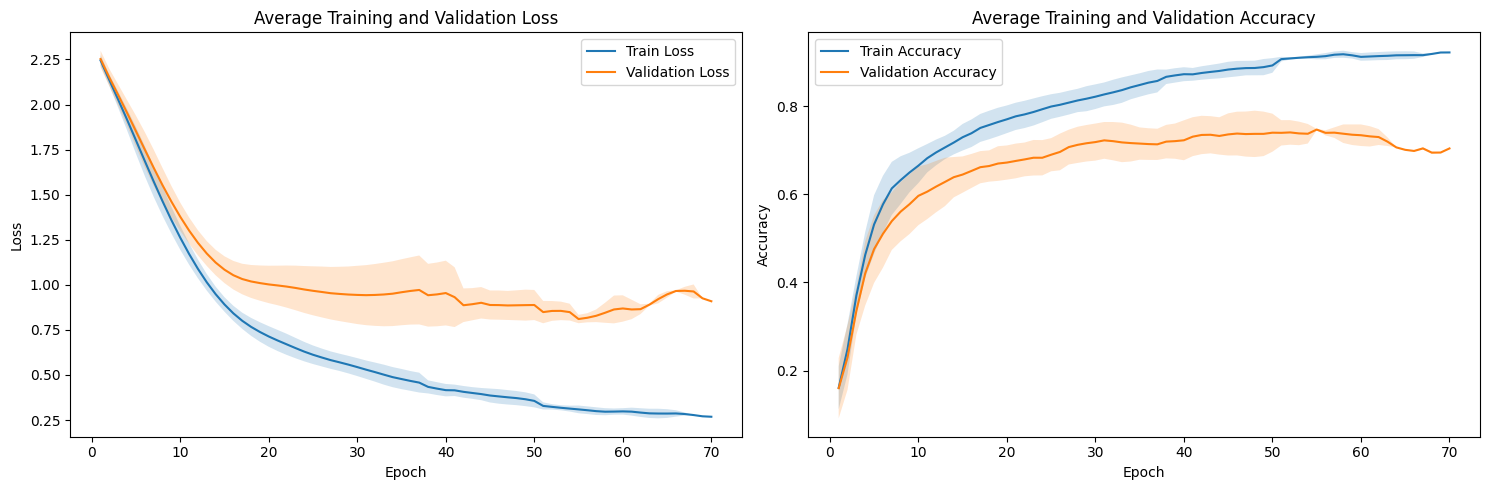

In [14]:
# Use your existing dataset
fold_metrics, curves = train_k_fold(
    dataset=dataset,
    hidden_channels=32,  # Reduced hidden channels
    dropout=0.3,         # Adjusted dropout
    epochs=200,
    lr=0.01
)

# Unpack curves
all_train_losses, all_val_losses, all_train_accs, all_val_accs = curves

# Plot average learning curves across folds
plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)

## Final Training 

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [18]:
def train_full_dataset(dataset, hidden_channels=32, dropout=0.3, epochs=200, lr=0.01, test_size=0.2, val_size=0.1, save_path='model_weights.pth'):
    """
    Train the model on the full dataset (with train, validation, and test splits) and save the final weights.
    Args:
        dataset: AudioGraphDataset instance
        hidden_channels: Number of hidden units in GCN
        dropout: Dropout rate
        epochs: Number of epochs
        lr: Learning rate
        test_size: Proportion of data to use as the test set
        val_size: Proportion of data to use as the validation set
        save_path: Path to save the final model weights
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Combine all folds into a single dataset
    full_data = Data(
        x=torch.cat([dataset[i].x for i in range(len(dataset))], dim=0),
        edge_index=torch.cat([dataset[i].edge_index for i in range(len(dataset))], dim=1),
        y=torch.cat([dataset[i].y for i in range(len(dataset))], dim=0)
    ).to(device)
    
    # Create train/validation/test splits
    num_samples = full_data.x.size(0)
    num_test = int(test_size * num_samples)
    num_val = int(val_size * num_samples)
    indices = torch.randperm(num_samples)  # Shuffle indices
    
    # Split indices into train, validation, and test sets
    test_indices = indices[:num_test]
    val_indices = indices[num_test:num_test + num_val]
    train_indices = indices[num_test + num_val:]
    
    # Create masks for train, validation, and test sets
    train_mask = torch.zeros(num_samples, dtype=torch.bool)
    train_mask[train_indices] = True
    val_mask = torch.zeros(num_samples, dtype=torch.bool)
    val_mask[val_indices] = True
    test_mask = torch.zeros(num_samples, dtype=torch.bool)
    test_mask[test_indices] = True
    
    # Add masks to the data object
    full_data.train_mask = train_mask.to(device)
    full_data.val_mask = val_mask.to(device)
    full_data.test_mask = test_mask.to(device)
    
    # Initialize model
    model = GCNAudioClassifier(
        num_features=128,  # VGGish features dimension
        hidden_channels=hidden_channels,
        num_classes=10,    # UrbanSound8K classes
        dropout=dropout
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)  # LR scheduling
    
    # Train on the training set with validation for early stopping
    print("\nTraining on the full dataset (with train, validation, and test splits)...")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model=model,
        data=full_data,
        optimizer=optimizer,
        epochs=epochs
    )
    
    # Evaluate on the test set
    test_metrics = evaluate_model(model, full_data)
    print("\nTest Set Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    # Save the final model weights
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")

In [ ]:
# Use your existing dataset
fold_metrics, curves = train_k_fold(
    dataset=dataset,
    hidden_channels=32,  # Reduced hidden channels
    dropout=0.3,         # Adjusted dropout
    epochs=200,
    lr=0.01
)

# Unpack curves
all_train_losses, all_val_losses, all_train_accs, all_val_accs = curves

# Plot average learning curves across folds
plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)

# Retrain on the full dataset (with train, validation, and test splits) and save the final model weights
train_full_dataset(
    dataset=dataset,
    hidden_channels=32,
    dropout=0.3,
    epochs=200,
    lr=0.01,
    test_size=0.2,  # 20% of data used as test set
    val_size=0.1,   # 10% of data used as validation set
    save_path='final_model_weights.pth'
)

Training on 10 folds...

Training Fold 1/10
Epoch 010, Train Loss: 1.2379, Train Acc: 0.6711, Val Loss: 1.3269, Val Acc: 0.6203
Epoch 020, Train Loss: 0.6823, Train Acc: 0.7808, Val Loss: 1.1980, Val Acc: 0.6139
Epoch 030, Train Loss: 0.5795, Train Acc: 0.8145, Val Loss: 1.3578, Val Acc: 0.6911
Early stopping at epoch 36
Fold 1 Test Metrics:
Accuracy: 0.7506
Precision: 0.7836
Recall: 0.7506
F1: 0.7321

Training Fold 2/10


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 010, Train Loss: 1.2585, Train Acc: 0.6651, Val Loss: 1.4811, Val Acc: 0.5488
Epoch 020, Train Loss: 0.6361, Train Acc: 0.8027, Val Loss: 1.0037, Val Acc: 0.6845
Epoch 030, Train Loss: 0.4674, Train Acc: 0.8553, Val Loss: 1.0832, Val Acc: 0.6595
Epoch 040, Train Loss: 0.3999, Train Acc: 0.8764, Val Loss: 1.2264, Val Acc: 0.6179
Early stopping at epoch 41
Fold 2 Test Metrics:
Accuracy: 0.7400
Precision: 0.8261
Recall: 0.7400
F1: 0.7348

Training Fold 3/10
Epoch 010, Train Loss: 1.3785, Train Acc: 0.6062, Val Loss: 1.4620, Val Acc: 0.6224


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 020, Train Loss: 0.6694, Train Acc: 0.7892, Val Loss: 0.9635, Val Acc: 0.6922
Epoch 030, Train Loss: 0.4485, Train Acc: 0.8670, Val Loss: 0.8896, Val Acc: 0.7471
Epoch 040, Train Loss: 0.3843, Train Acc: 0.8887, Val Loss: 0.9473, Val Acc: 0.7368
Early stopping at epoch 48
Fold 3 Test Metrics:
Accuracy: 0.6262
Precision: 0.6337
Recall: 0.6262
F1: 0.6161

Training Fold 4/10
Epoch 010, Train Loss: 1.3492, Train Acc: 0.5532, Val Loss: 1.5137, Val Acc: 0.5450
Epoch 020, Train Loss: 0.8203, Train Acc: 0.7345, Val Loss: 1.1753, Val Acc: 0.6523


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 0.5071, Train Acc: 0.8413, Val Loss: 0.7801, Val Acc: 0.6991
Epoch 040, Train Loss: 0.4020, Train Acc: 0.8814, Val Loss: 0.7065, Val Acc: 0.7793
Epoch 050, Train Loss: 0.3385, Train Acc: 0.9024, Val Loss: 0.7153, Val Acc: 0.7694
Epoch 060, Train Loss: 0.2993, Train Acc: 0.9163, Val Loss: 0.7340, Val Acc: 0.7781
Early stopping at epoch 63
Fold 4 Test Metrics:
Accuracy: 0.7208
Precision: 0.7311
Recall: 0.7208
F1: 0.7225

Training Fold 5/10
Epoch 010, Train Loss: 1.2068, Train Acc: 0.6539, Val Loss: 1.2496, Val Acc: 0.6141


/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/ai-132/miniconda3

Epoch 020, Train Loss: 0.6641, Train Acc: 0.7831, Val Loss: 0.8348, Val Acc: 0.6916
Epoch 030, Train Loss: 0.5734, Train Acc: 0.8079, Val Loss: 0.8685, Val Acc: 0.7054
Epoch 040, Train Loss: 0.4378, Train Acc: 0.8593, Val Loss: 0.9003, Val Acc: 0.7095
Early stopping at epoch 42
Fold 5 Test Metrics:
Accuracy: 0.7596
Precision: 0.7902
Recall: 0.7596
F1: 0.7505

Training Fold 6/10
Epoch 010, Train Loss: 1.1212, Train Acc: 0.6830, Val Loss: 1.3498, Val Acc: 0.6276
Epoch 020, Train Loss: 0.6402, Train Acc: 0.8053, Val Loss: 1.0337, Val Acc: 0.6303
Epoch 030, Train Loss: 0.4936, Train Acc: 0.8469, Val Loss: 0.9993, Val Acc: 0.6316
Epoch 040, Train Loss: 0.4022, Train Acc: 0.8785, Val Loss: 1.0148, Val Acc: 0.6816
Epoch 050, Train Loss: 0.3398, Train Acc: 0.8993, Val Loss: 1.1307, Val Acc: 0.6658
Early stopping at epoch 54
Fold 6 Test Metrics:
Accuracy: 0.7663
Precision: 0.7757
Recall: 0.7663
F1: 0.7650

Training Fold 7/10
Epoch 010, Train Loss: 1.1882, Train Acc: 0.6993, Val Loss: 1.3937, Va

/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_5402/886109207.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 